In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data_path = 'Pneumonia_Dataset/train'
filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
df

filepaths      label
0      Pneumonia_Dataset/train\NORMAL\IM-0115-0001.jpeg     NORMAL
1      Pneumonia_Dataset/train\NORMAL\IM-0117-0001.jpeg     NORMAL
2      Pneumonia_Dataset/train\NORMAL\IM-0119-0001.jpeg     NORMAL
3      Pneumonia_Dataset/train\NORMAL\IM-0122-0001.jpeg     NORMAL
4      Pneumonia_Dataset/train\NORMAL\IM-0125-0001.jpeg     NORMAL
...                                                 ...        ...
5211  Pneumonia_Dataset/train\PNEUMONIA\person99_vir...  PNEUMONIA
5212  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5213  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5214  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5215  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA

[5216 rows x 2 columns]

In [4]:
test_data_path = 'Pneumonia_Dataset/test'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test = pd.concat([Fseries , Lseries] , axis = 1)
test

filepaths      label
0      Pneumonia_Dataset/test\NORMAL\IM-0001-0001.jpeg     NORMAL
1      Pneumonia_Dataset/test\NORMAL\IM-0003-0001.jpeg     NORMAL
2      Pneumonia_Dataset/test\NORMAL\IM-0005-0001.jpeg     NORMAL
3      Pneumonia_Dataset/test\NORMAL\IM-0006-0001.jpeg     NORMAL
4      Pneumonia_Dataset/test\NORMAL\IM-0007-0001.jpeg     NORMAL
..                                                 ...        ...
619  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
620  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
621  Pneumonia_Dataset/test\PNEUMONIA\person97_bact...  PNEUMONIA
622  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA
623  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA

[624 rows x 2 columns]

In [5]:
valid_data_path = 'Pneumonia_Dataset/val'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
valid = pd.concat([Fseries , Lseries] , axis = 1)
valid

filepaths      label
0      Pneumonia_Dataset/test\NORMAL\IM-0001-0001.jpeg     NORMAL
1      Pneumonia_Dataset/test\NORMAL\IM-0003-0001.jpeg     NORMAL
2      Pneumonia_Dataset/test\NORMAL\IM-0005-0001.jpeg     NORMAL
3      Pneumonia_Dataset/test\NORMAL\IM-0006-0001.jpeg     NORMAL
4      Pneumonia_Dataset/test\NORMAL\IM-0007-0001.jpeg     NORMAL
..                                                 ...        ...
619  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
620  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
621  Pneumonia_Dataset/test\PNEUMONIA\person97_bact...  PNEUMONIA
622  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA
623  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA

[624 rows x 2 columns]

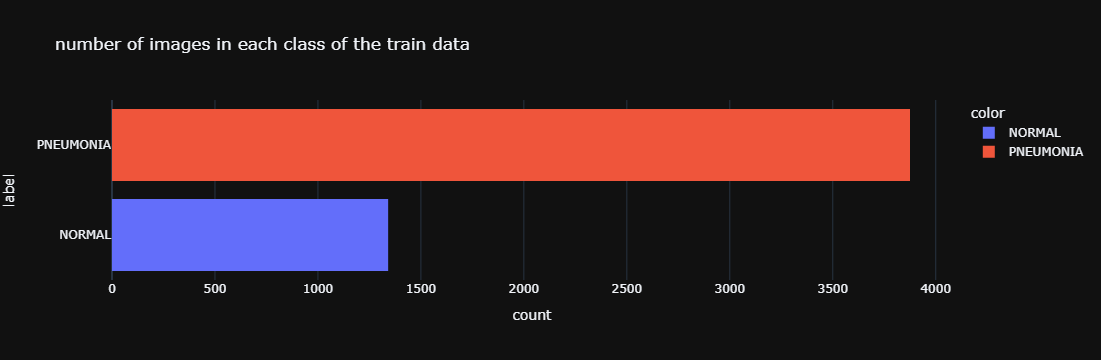

In [6]:
fig= px.histogram(data_frame= df,
           y= df['label'],
           template='plotly_dark',
           color= df['label'].values,
           title='number of images in each class of the train data')
fig.show()

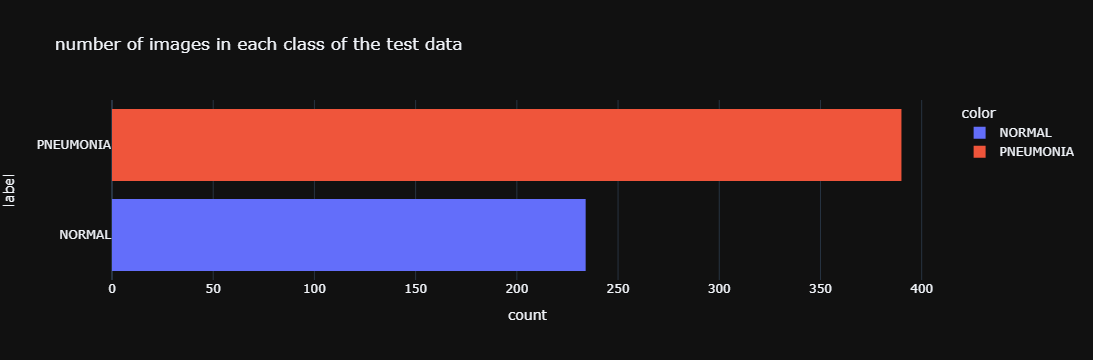

In [7]:
fig= px.histogram(data_frame= test,
           y= test['label'],
           template='plotly_dark',
           color=test['label'].values,
           title='number of images in each class of the test data')
fig.show()

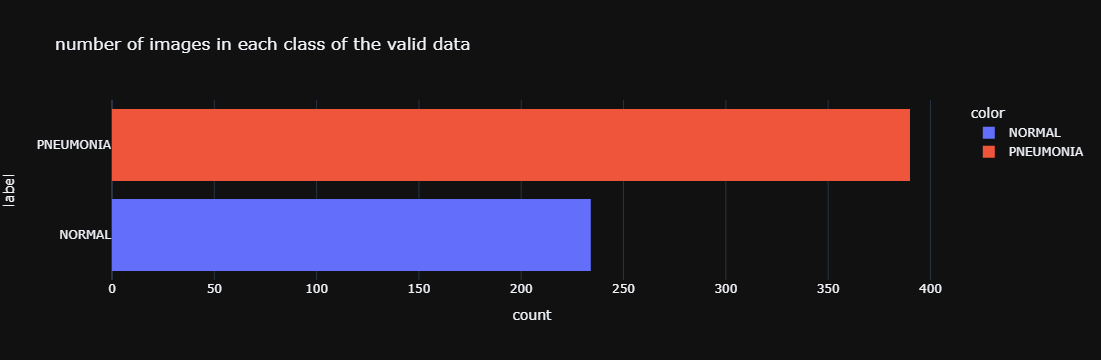

In [8]:
fig= px.histogram(data_frame= valid,
           y= valid['label'],
           template='plotly_dark',
           color=valid['label'].values,
           title='number of images in each class of the valid data')
fig.show()

In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle= True, random_state= 42)
valid_df, test_df= train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= 42)

In [10]:
img_size = (224 ,224)
batch_size = 16
img_shape= (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)


Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


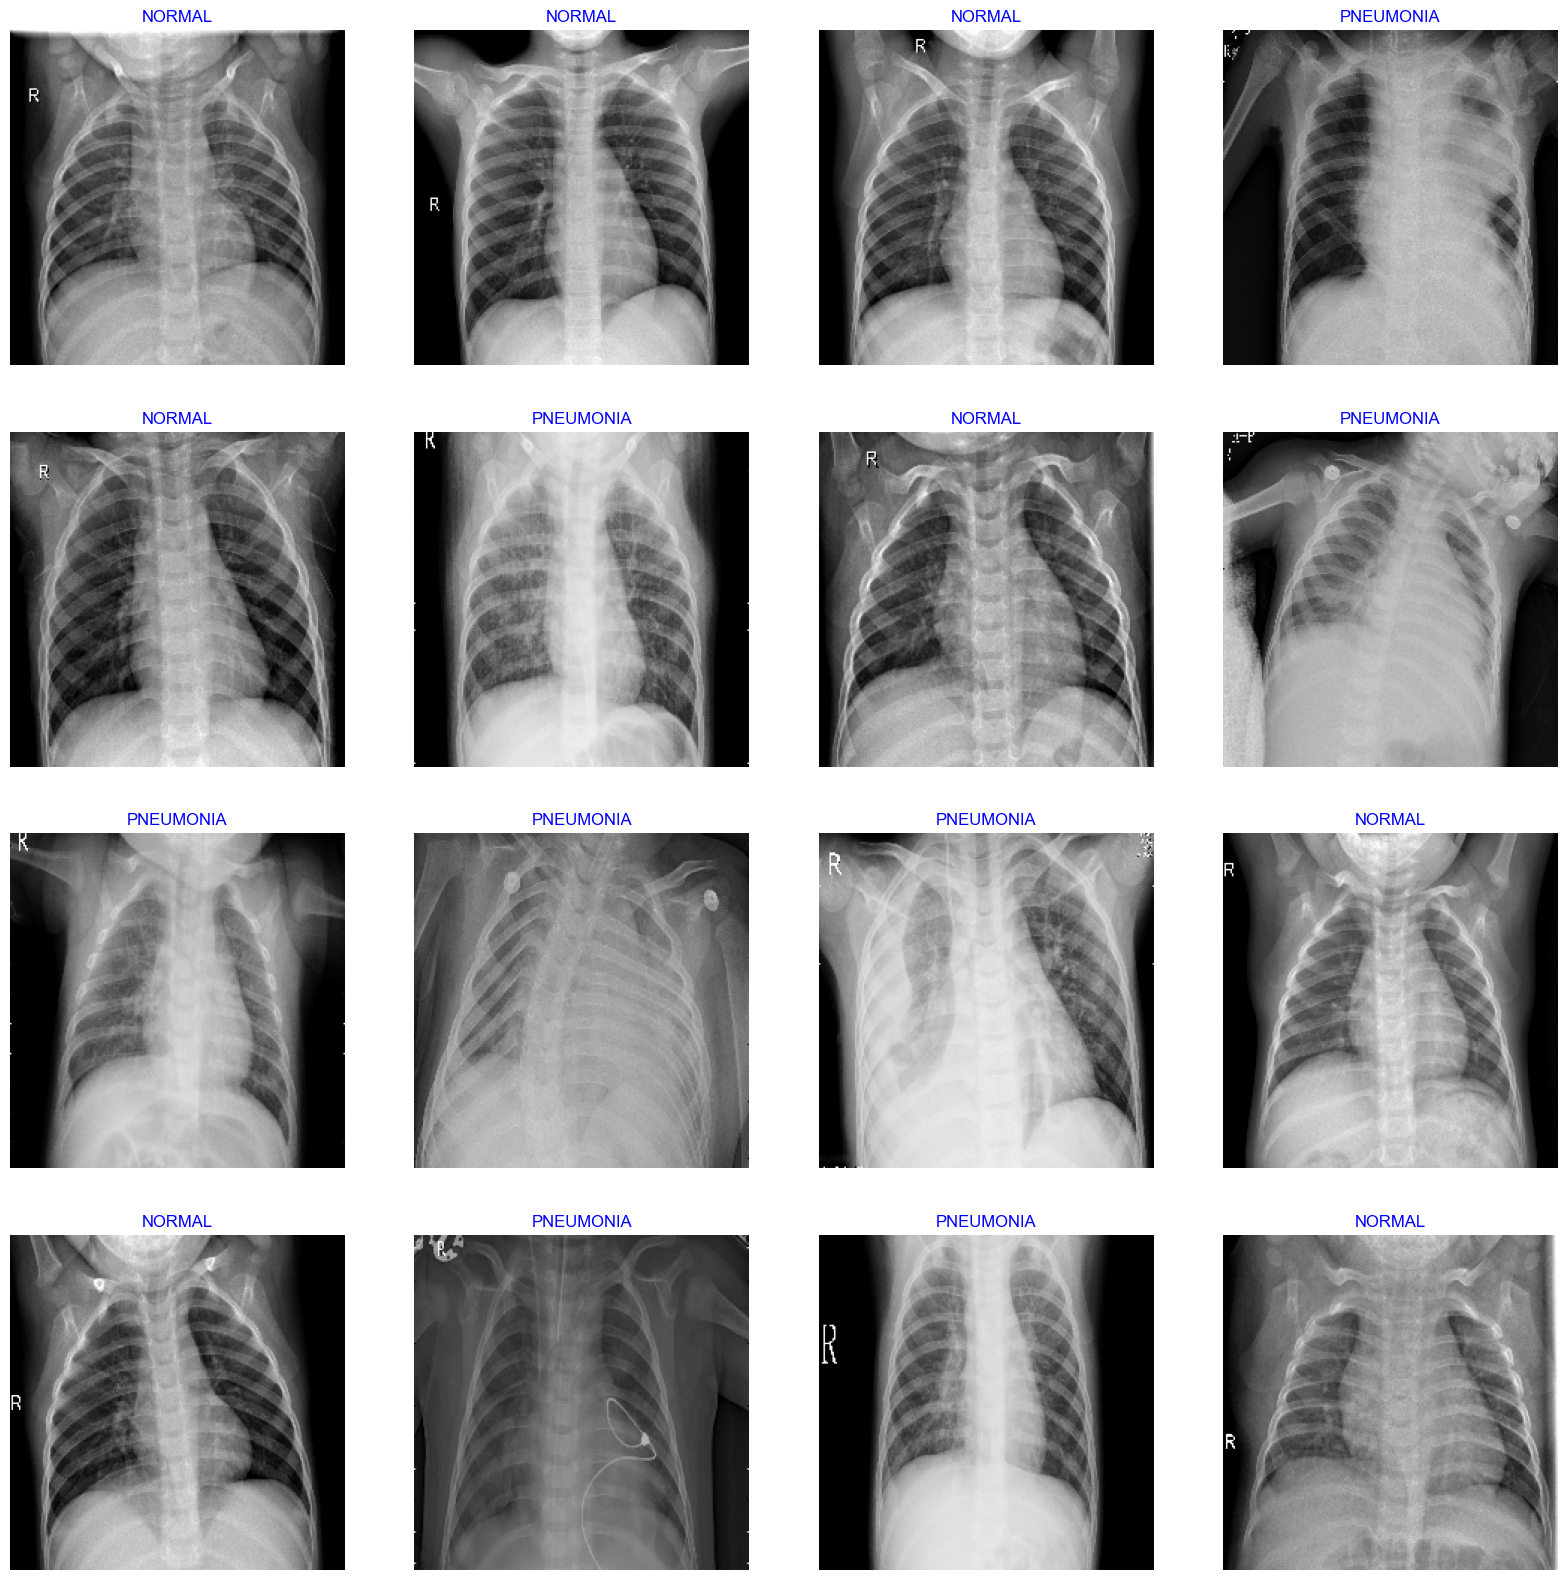

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [12]:
img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = MobileNet(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [13]:
Epochs = 10
history = model.fit(x= train_gen , epochs = Epochs, verbose = 1, validation_data= valid_gen,validation_steps = None , shuffle = False)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 266s 969ms/step - accuracy: 0.7932 - loss: 18.4735 - val_accuracy: 0.9441 - val_loss: 17.2145
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 244s 933ms/step - accuracy: 0.9031 - loss: 14.5926 - val_accuracy: 0.8898 - val_loss: 12.4978
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9068 - loss: 9.6147 - val_accuracy: 0.7204 - val_loss: 7.1313
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8598 - loss: 6.6585 - val_accuracy: 0.7188 - val_loss: 5.9529
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7892 - loss: 5.9589 - val_accuracy: 0.7157 - val_loss: 5.5828
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7795 - loss: 5.5947 - val_accuracy: 0.7157 - val_loss: 5.3065
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7447 - loss: 5.2651 - val_accuracy: 0.7141 - val_loss: 5.0489
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 240s 921ms/step - accuracy: 0.7631 - loss: 5.03

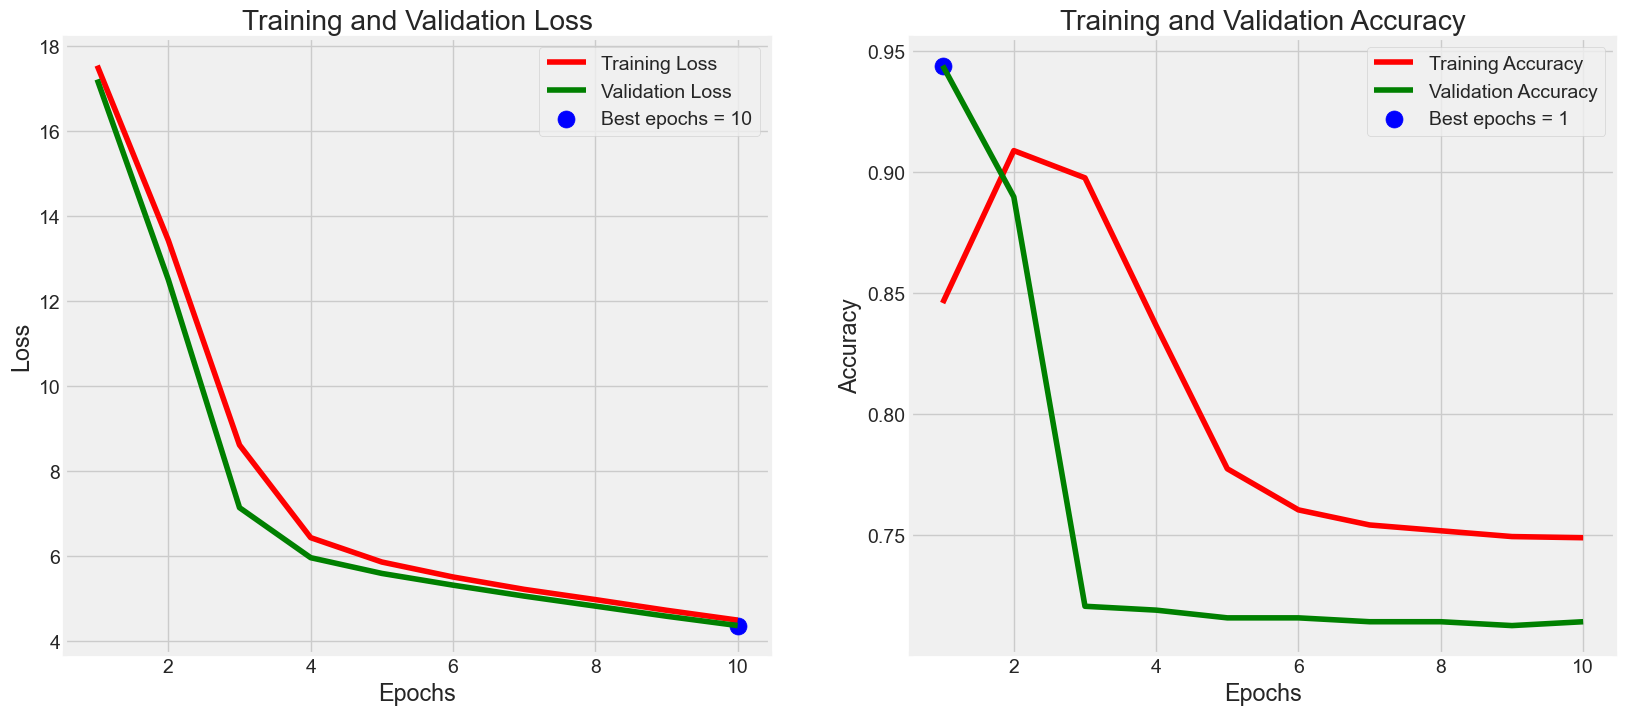

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [15]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.7539 - loss: 4.3532
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.8076 - loss: 4.3353
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.7580 - loss: 4.3438
Train Loss:  4.351770401000977
Train Accuracy:  0.7421875
--------------------
Validation Loss:  4.34444522857666
Validation Accuracy:  0.765625
--------------------
Test Loss:  4.349198341369629
Test Accuracy:  0.7578125


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step


Found 418 validated image filenames belonging to 2 classes.


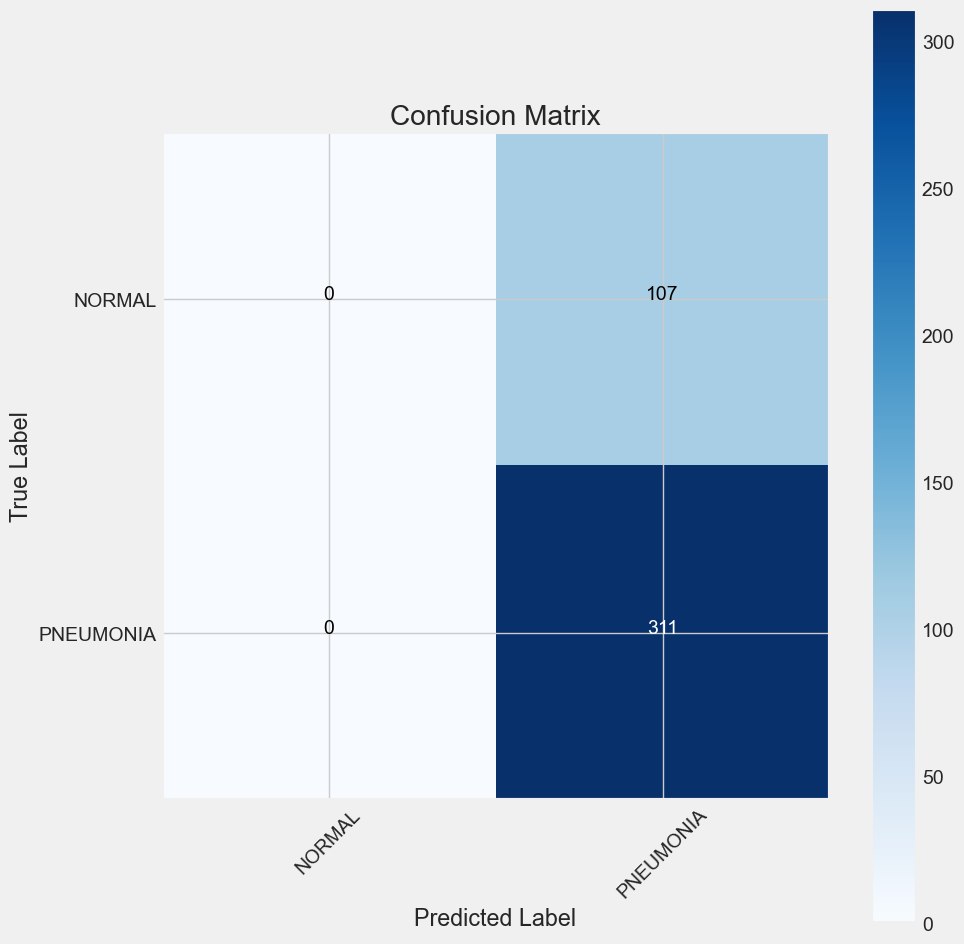

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
# cm = confusion_matrix(test_gen.classes, y_pred)

# Define test_gen before plotting the confusion matrix
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

# Plot the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
print(classification_report(test_gen.classes, y_pred , target_names= classes )) 

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       107
   PNEUMONIA       0.74      1.00      0.85       311

    accuracy                           0.74       418
   macro avg       0.37      0.50      0.43       418
weighted avg       0.55      0.74      0.63       418



In [19]:
recall = recall_score(test_gen.classes, y_pred, average='weighted')
f1 = f1_score(test_gen.classes, y_pred, average='weighted')

print("Recall:", recall)
print("F1 Score:", f1)

Recall: 0.7440191387559809
F1 Score: 0.634814683547627
